# *[Working Title]* Alpha and 1/*f* Slope in Resting-State EEG: Associations with Cognitive Decline in Older Adults

Alicia J. Campbell, Toomas Erik Anijärv, Mikael Johansson, Jim Lagopoulos, Daniel F. Hermens, Jacob M. Levenstein, & Sophie C. Andrews

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from scipy import stats
import pingouin as pg
import warnings
import statsmodels.stats.multitest as smm
from HLR import HierarchicalLinearRegression

warnings.simplefilter(action='ignore', category=FutureWarning)

## Cleaning data

### *rsEEG measures (detailed exclusions)*

#### Exclusion reasons:

**1. Less than 50% epochs remaining after artifact rejection (do not use for alpha or aperiodic analysis)**
       
        ID: [36] n=1

**2. The fit of the parameterized power spectrum to the original PSD was below a cut-off of explained variance (R2) < .9 (do not use for alpha or aperiodic analysis)**

        Fronto-central: [ID : 9, 93, 119] n=3

**3. Bad aperiodic fit as per visual inspection (i.e., fit includes significant omissions of signal) (do not use for alpha or aperiodic analysis)**

        Parieto-occipital: [ID : 14, 118, 119] n=3

        Fronto-central: [ID : 16, 38, 61, 118] n=4

**4. No individual alpha peak could be detected. (still use for aperiodic analyses)**

        Parieto-occipital: [ID : 61, 75, 93] n=3
        
        Fronto-central [ID : 14, 80, 130] n=3

**5. Any of the extracted parameters exceeded a threshold of 3 standard deviations above or below the mean of the sample**

        IAF_fc [ID : 109] --> above 3 SD n=1

---

#### Exclusions together per measure:

        IAF_po [ID :  14, 16, 36, 113, 118, 120] n=6

        Exponent_po [ID :  14, 36, 113, 118, 119] n=6

        IAF_fc [ID : 9, 14, 16, 36, 38, 61, 80, 93, 109, 119, 118, 130] n=11
        
        Exponent_fc [ID : 9, 16, 36, 38, 61, 93, 118, 119] n=7

In [2]:
fullsample_df = pd.read_csv('data/LEISURE_T1_demo_CANTAB_NP_rsEEG_RAW.csv')

### Exclusions

In [3]:
# List of variables to process
variables = ['Exponent_po', 'Exponent_fc', 'IAF_po', 'IAF_fc']

# Dictionary of subjects to exclude for each variable
exclude_subjects = {
    'Exponent_po': [14, 36, 118, 119],
    'Exponent_fc': [9, 16, 36, 38, 61, 93, 118, 119],
    'IAF_po': [14, 36, 61, 75, 93, 118, 119 ],
    'IAF_fc': [9, 14, 16, 36, 38, 61, 80, 93, 109, 118, 119, 130]
}

# Exclude specified subjects and create new columns with the suffix '_OR'
for var in variables:
    subjects_to_exclude = exclude_subjects.get(var, [])
    mask = fullsample_df['Subject'].isin(subjects_to_exclude)
    fullsample_df[var + '_OR'] = fullsample_df.loc[~mask, var]

### *Demographics*

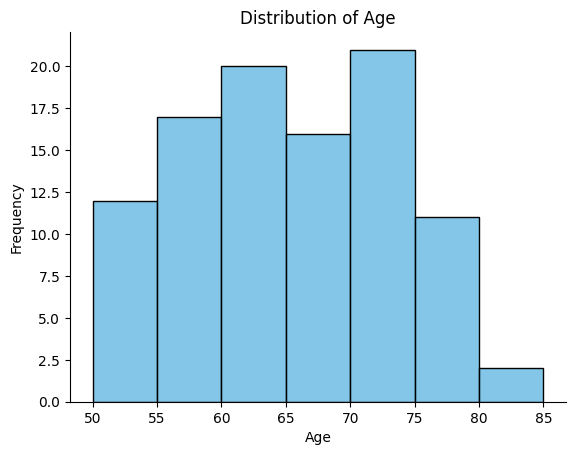

In [4]:
bins = range(50, 90, 5)  # Creates bins from 50 to 85 with a step of 5 years

sns.histplot(fullsample_df['Age'], bins=bins, color='#5ab4e0')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.title('Distribution of Age')

sns.despine()

# plt.savefig('results/plots/age_distribution.tiff', format='tiff', dpi=300, bbox_inches='tight')

plt.show()

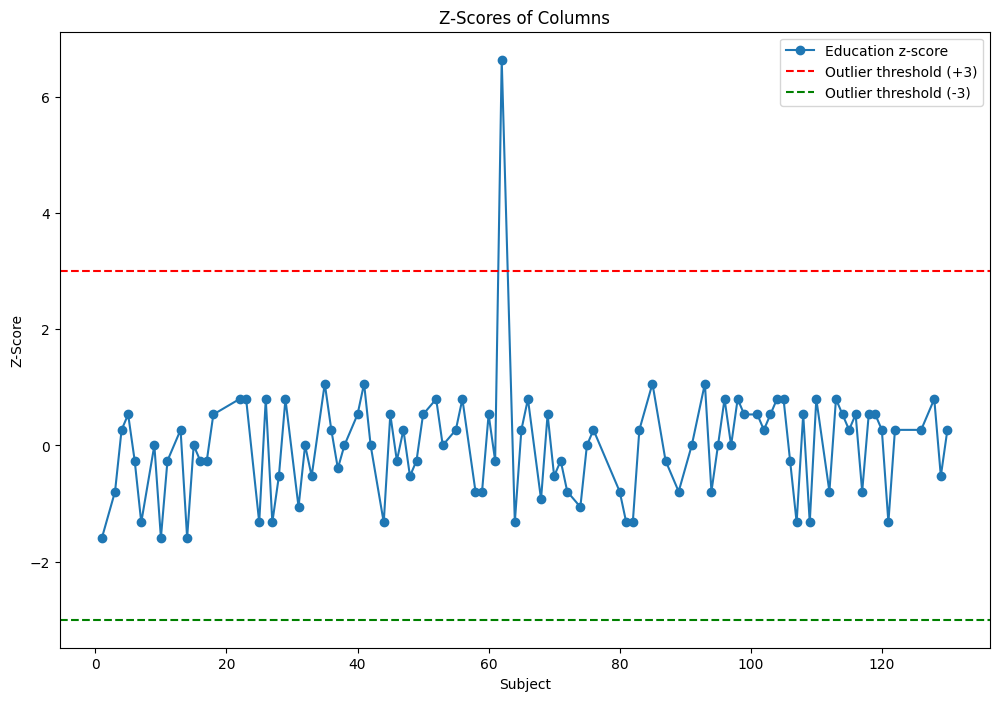

Outliers found:
Subject: 62, Column: Education, Value: 40.0, Z-Score: 6.64


In [5]:
columns_to_check = ['Education'] 
fullsample_df = fullsample_df.dropna(subset=columns_to_check)

# Plotting z-scores for visualization
plt.figure(figsize=(12, 8))
for col in columns_to_check:
    # Calculate z-scores on the fly
    zs = stats.zscore(fullsample_df[col])
    plt.plot(fullsample_df['Subject'], zs, marker='o', linestyle='-', label=f'{col} z-score')
plt.axhline(3, color='red', linestyle='--', label='Outlier threshold (+3)')
plt.axhline(-3, color='green', linestyle='--', label='Outlier threshold (-3)')
plt.xlabel('Subject')
plt.ylabel('Z-Score')
plt.title('Z-Scores of Columns')
plt.legend()
plt.show()

# Identify outliers and the associated subject and column
outliers = []
for col in columns_to_check:
    zs = stats.zscore(fullsample_df[col])
    for idx, z in enumerate(zs):
        if z > 3 or z < -3:
            outliers.append((fullsample_df.loc[idx, 'Subject'], col, fullsample_df.loc[idx, col], z))

# Print outlier information
print("Outliers found:")
for outlier in outliers:
    print(f"Subject: {outlier[0]}, Column: {outlier[1]}, Value: {outlier[2]}, Z-Score: {outlier[3]:.2f}")

# UNCOMMENT TO ADJUST OUTLIER/S
# Adjust outliers and create new columns with suffix _OA
for col in columns_to_check:
    # Copy the original column to a new one with the suffix _OA
    fullsample_df[col + '_OA'] = fullsample_df[col]
    
    # Calculate z-scores
    zs = stats.zscore(fullsample_df[col])
    
    # Adjust outliers
    for idx, z in enumerate(zs):
        if z > 3:
            # Find the nearest acceptable value (<= 3 z-score)
            nearest_acceptable_value = fullsample_df.loc[zs <= 3, col].max()
            fullsample_df.loc[idx, col + '_OA'] = nearest_acceptable_value + 1
        elif z < -3:
            # Find the nearest acceptable value (>= -3 z-score)
            nearest_acceptable_value = fullsample_df.loc[zs >= -3, col].min()
            fullsample_df.loc[idx, col + '_OA'] = nearest_acceptable_value - 1

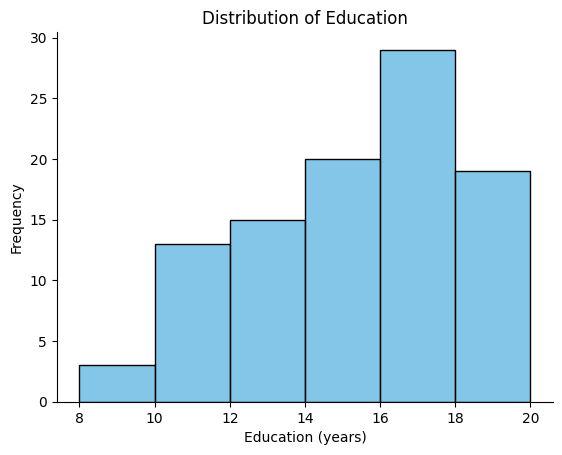

In [6]:
bins = range(8, 22, 2)

sns.histplot(fullsample_df['Education_OA'], bins=bins, color='#5ab4e0')
plt.xlabel('Education (years)')
plt.ylabel('Frequency')
plt.title('Distribution of Education')
sns.despine()
# plt.show()

### *Cognitive scores*

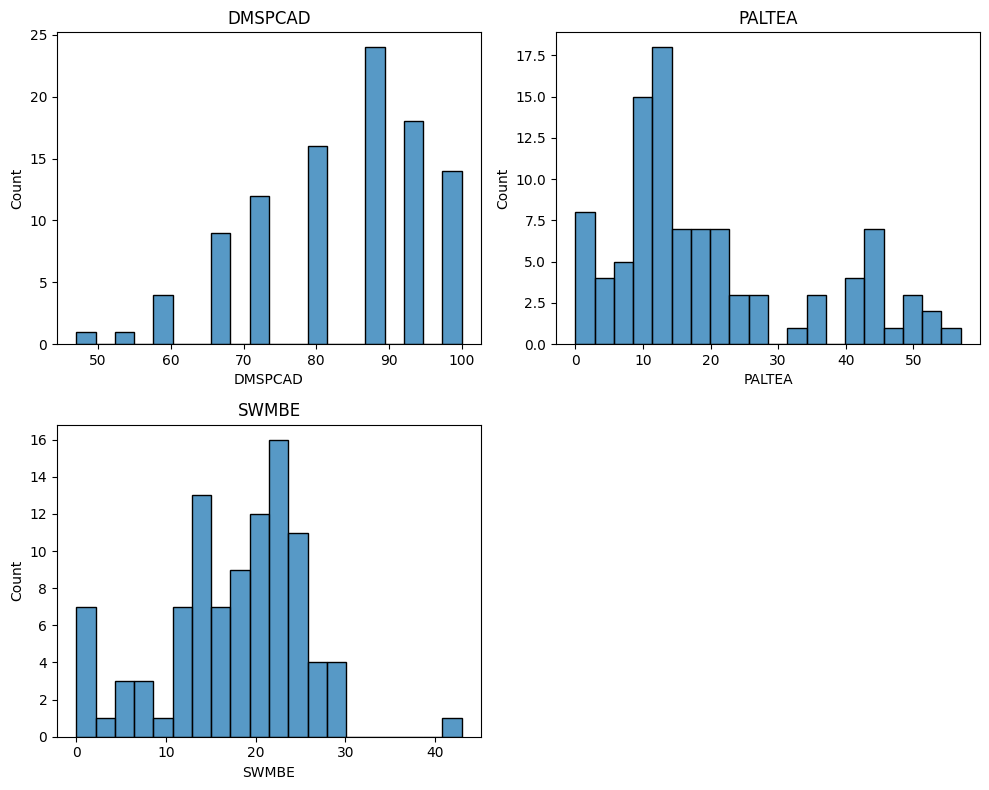

In [7]:
# Distribution

# List of variables to plot
variables = ['DMSPCAD', 'PALTEA', 'SWMBE']

# Number of variables
num_vars = len(variables)

# Number of rows and columns for the subplot grid
num_cols = 2
num_rows = (num_vars + num_cols - 1) // num_cols

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each variable in a separate subplot
for i, var in enumerate(variables):
    # Filter out values of 9999.00
    data = fullsample_df[fullsample_df[var] != 9999.00][var].dropna()
    sns.histplot(data, bins=20, kde=False, ax=axes[i])
    axes[i].set_title(var)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
# plt.show()

In [8]:
# Remove outliers

# List of variables to process
variables = ['SWMBE']

# Dictionary of subjects to exclude for each variable
exclude_subjects = {
    'SWMBE': [44]
}

# Exclude specified subjects and create new columns with the suffix '_OR'
for var in variables:
    subjects_to_exclude = exclude_subjects.get(var, [])
    mask = fullsample_df['Subject'].isin(subjects_to_exclude)
    fullsample_df[var + '_OR'] = fullsample_df.loc[~mask, var]

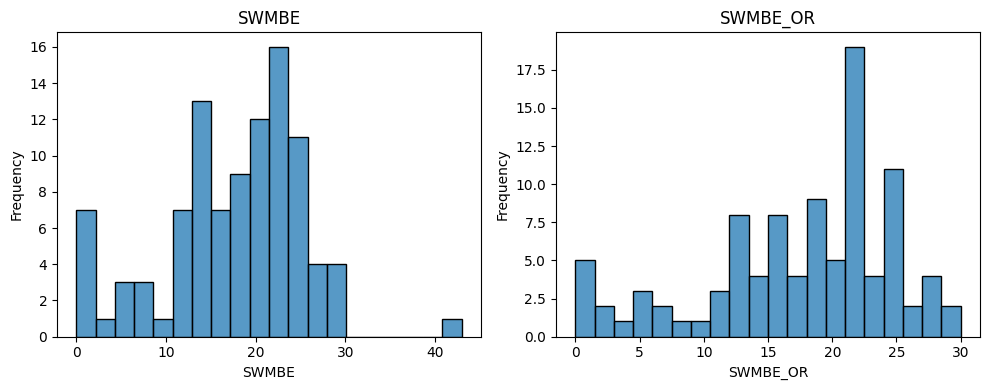

In [9]:
# List of variables to plot
variables = ['SWMBE', 'SWMBE_OR']

# Number of variables
num_vars = len(variables)

# Number of rows and columns for the subplot grid
num_cols = 2  # Adjust based on the number of variables
num_rows = (num_vars + num_cols - 1) // num_cols

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each variable in a separate subplot
for i, var in enumerate(variables):
    data = fullsample_df[var].dropna()  # Filter out missing values
    sns.histplot(data, bins=20, kde=False, ax=axes[i])
    axes[i].set_title(var)
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
# plt.show()

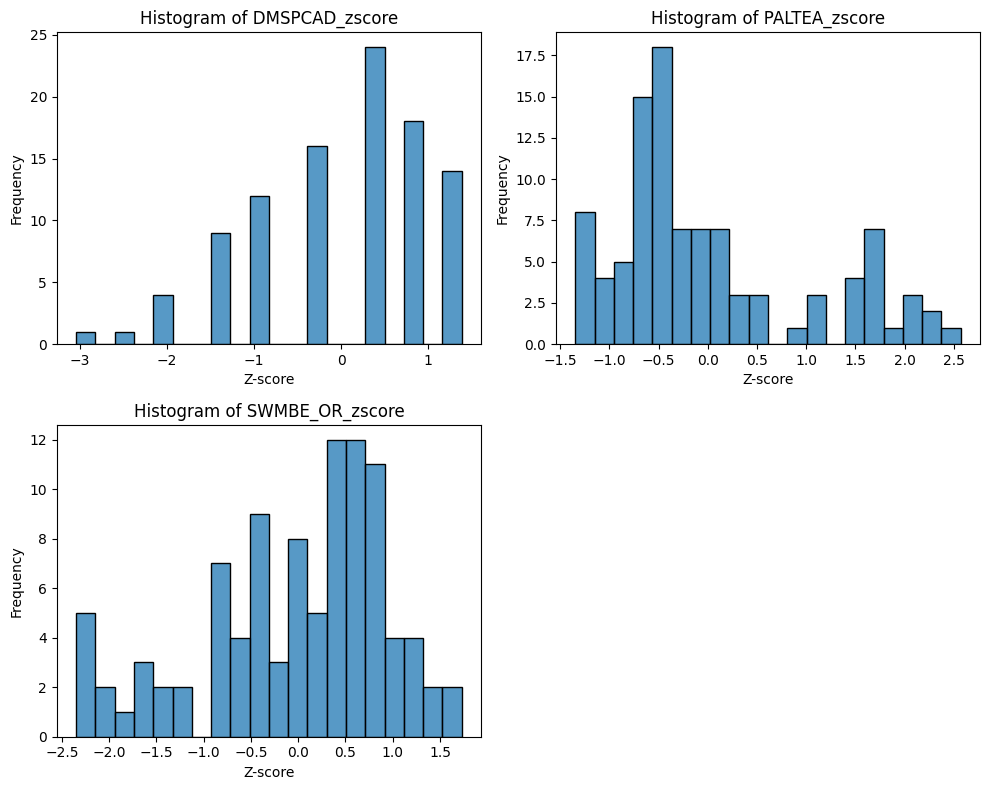

In [10]:
# Z score clean scores

# Assuming df is your DataFrame
columns_to_zscore = ['DMSPCAD', 'PALTEA', 'SWMBE_OR']

for column in columns_to_zscore:
    # Calculate the z-score, excluding missing data
    fullsample_df[column + '_zscore'] = fullsample_df[column].transform(lambda x: stats.zscore(x, nan_policy='omit'))

# Number of variables
num_vars = len(columns_to_zscore)

# Number of rows and columns for the subplot grid
num_cols = 2
num_rows = (num_vars + num_cols - 1) // num_cols

# Create a figure and a grid of subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 4 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot each Z-score variable in a separate subplot
for i, column in enumerate(columns_to_zscore):
    zscore_column = column + '_zscore'
    data = fullsample_df[zscore_column].dropna()  # Drop missing values
    sns.histplot(data, bins=20, kde=False, ax=axes[i])
    axes[i].set_title(f'Histogram of {zscore_column}')
    axes[i].set_xlabel('Z-score')
    axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Adjust layout
plt.tight_layout()
# plt.show()


### *Create a data frame with now clean data*

In [11]:
# List of columns to include in the new DataFrame
columns_to_include = ['Subject', 'Age', 'Gender_F', 'Education_OA', 'Handedness_right', 
                      'IAF_po_OR', 'IAF_fc_OR', 'Exponent_po_OR', 'Exponent_fc_OR',
                      'DMSPCAD', 'PALTEA', 'SWMBE_OR',
                      'DMSPCAD_zscore', 'PALTEA_zscore', 'SWMBE_OR_zscore']

# Create a new DataFrame with only the selected columns and make a copy
fullsample_df_CLEAN = fullsample_df[columns_to_include].copy()

# Dictionary of old column names and new column names
new_column_names = {
    'Education_OA': 'Education',
    'IAF_po_OR': 'IAF_po',
    'IAF_fc_OR': 'IAF_fc',
    'Exponent_po_OR': 'Exponent_po',
    'Exponent_fc_OR': 'Exponent_fc',
    'DMSPCAD_zscore': 'DMSPCAD_z',
    'PALTEA_zscore': 'PALTEA_z',
    'SWMBE_OR_zscore': 'SWMBE_OR_z'
}

# Rename the columns in the new DataFrame
fullsample_df_CLEAN.rename(columns=new_column_names, inplace=True)

### *Compute interaction terms*

**Interactions:**

1. Age * Exponent_fc
2. Age * IAF_fc
3. IAF_fc * Exponent_fc
4. Age * Exponent_po
5. Age * IAF_po
6. IAF_po * Exponent_po

In [12]:
# Compute z-scores
interactions_zscore = ['Age', 'Exponent_po', 'Exponent_fc' ,'IAF_po', 'IAF_fc']
for col in interactions_zscore:
    fullsample_df_CLEAN[col + '_zscore'] = stats.zscore(fullsample_df_CLEAN[col], nan_policy='omit')

# Interaction terms dictionary
interaction_terms = {
    'Age_Exponent_po': ['Age_zscore', 'Exponent_po_zscore'],
    'Age_IAF_po': ['Age_zscore', 'IAF_po_zscore'],
    'IAF_Exponent_po': ['IAF_po_zscore', 'Exponent_po_zscore'],
    'Age_Exponent_fc': ['Age_zscore', 'Exponent_fc_zscore'],
    'Age_IAF_fc': ['Age_zscore', 'IAF_fc_zscore'],
    'IAF_Exponent_fc': ['IAF_fc_zscore', 'Exponent_fc_zscore']
}

# Compute interaction terms
for interaction_name, columns in interaction_terms.items():
    col1, col2 = columns
    mask = fullsample_df_CLEAN[[col1, col2]].notna().all(axis=1)
    fullsample_df_CLEAN.loc[mask, interaction_name] = fullsample_df_CLEAN.loc[mask, col1] * fullsample_df_CLEAN.loc[mask, col2]

# fullsample_df_CLEAN.to_csv('data/LEISURE_T1_demo_CANTAB_NP_rsEEG_CLEAN.csv', index=False)

## Analysis

In [2]:
fullsample_df_CLEAN = pd.read_csv('data/LEISURE_T1_demo_CANTAB_NP_rsEEG_CLEAN.csv')

### Sample descriptives

In [3]:
num_females = fullsample_df_CLEAN['Gender_F'].sum()
print(f"Number of females: {num_females}")

num_righthanded = fullsample_df_CLEAN['Handedness_right'].sum()
print(f"Number of right handed: {num_righthanded}")

descriptives_df = fullsample_df_CLEAN.describe()

# descriptives_df.to_csv('results/sampledescriptives.csv')

descriptives_df

Number of females: 80
Number of right handed: 86


,Subject,Age,Gender_F,Education,Handedness_right,IAF_po,IAF_fc,Exponent_po,Exponent_fc,DMSPCAD,...,Exponent_po_zscore,Exponent_fc_zscore,IAF_po_zscore,IAF_fc_zscore,Age_Exponent_po,Age_IAF_po,IAF_Exponent_po,Age_Exponent_fc,Age_IAF_fc,IAF_Exponent_fc
count,99.000000,99.000000,99.000000,99.000000,99.000000,92.000000,87.000000,95.000000,91.000000,99.000000,...,9.500000e+01,9.100000e+01,9.200000e+01,8.700000e+01,95.000000,92.000000,92.000000,91.000000,87.000000,87.000000
mean,65.797980,65.470338,0.808081,14.787879,0.868687,9.735978,9.608391,0.933270,0.942223,83.444444,...,7.009013e-16,2.234171e-16,-3.252833e-15,6.967607e-16,-0.184459,-0.224932,-0.172496,-0.206263,-0.303196,-0.105430
std,37.881927,8.295839,0.395814,2.857224,0.339461,1.087729,1.122323,0.185328,0.213160,12.024823,...,1.005305e+00,1.005540e+00,1.005479e+00,1.005797e+00,0.947671,0.857009,1.159849,0.959112,0.892611,0.895697
min,1.000000,50.162229,0.000000,9.000000,0.000000,7.030000,7.000000,0.498648,0.417352,47.000000,...,-2.357585e+00,-2.475976e+00,-2.501364e+00,-2.337573e+00,-2.929203,-2.887128,-3.844358,-3.634493,-3.343505,-2.809012
25%,34.000000,59.541744,1.000000,12.500000,1.000000,9.035000,8.830000,0.800972,0.804652,73.000000,...,-7.176428e-01,-6.489630e-01,-6.479733e-01,-6.975739e-01,-0.739178,-0.803871,-0.415512,-0.617262,-0.795891,-0.412322
50%,65.000000,65.203302,1.000000,15.000000,1.000000,9.755000,9.630000,0.946649,0.935343,87.000000,...,7.257493e-02,-3.245346e-02,1.758340e-02,1.936561e-02,-0.080518,-0.132366,-0.137690,-0.086222,-0.161937,-0.029502
75%,100.000000,71.689926,1.000000,17.000000,1.000000,10.532500,10.520000,1.048454,1.075428,93.000000,...,6.248112e-01,6.283704e-01,7.362922e-01,8.169608e-01,0.276931,0.169300,0.116413,0.260623,0.187166,0.318049
max,130.000000,84.036269,1.000000,20.000000,1.000000,11.900000,12.320000,1.364308,1.557218,100.000000,...,2.338146e+00,2.901122e+00,2.000388e+00,2.430075e+00,2.755038,2.119001,4.271717,2.164843,1.499284,2.460870


In [4]:
correlation_list = ['DMSPCAD_z', 'PALTEA_z', 'SWMBE_OR_z', 'Exponent_po', 'Exponent_fc', 'IAF_po', 'IAF_fc', 'Age']
corr = pg.rcorr(fullsample_df_CLEAN[correlation_list], method='spearman', stars=False)
corr

,DMSPCAD_z,PALTEA_z,SWMBE_OR_z,Exponent_po,Exponent_fc,IAF_po,IAF_fc,Age
DMSPCAD_z,-,0.113,0.5,0.883,0.913,0.917,0.236,0.023
PALTEA_z,-0.16,-,0.015,0.863,0.539,0.686,0.887,0.001
SWMBE_OR_z,-0.069,0.244,-,0.318,0.472,0.022,0.082,0.000
Exponent_po,0.015,0.018,-0.104,-,0.000,0.05,0.011,0.072
Exponent_fc,-0.012,-0.065,-0.077,0.635,-,0.262,0.335,0.066
IAF_po,-0.011,0.043,-0.241,-0.205,-0.12,-,0.000,0.015
IAF_fc,0.128,-0.015,-0.189,-0.272,-0.105,0.808,-,0.004
Age,-0.229,0.328,0.389,-0.185,-0.194,-0.253,-0.303,-


In [5]:
correlation_list = ['DMSPCAD_z', 'PALTEA_z', 'SWMBE_OR_z', 'Exponent_po', 'Exponent_fc', 'IAF_po', 'IAF_fc', 'Age']
corr = pg.rcorr(fullsample_df_CLEAN[correlation_list], method='spearman', stars=False, padjust='fdr_bh')
corr

,DMSPCAD_z,PALTEA_z,SWMBE_OR_z,Exponent_po,Exponent_fc,IAF_po,IAF_fc,Age
DMSPCAD_z,-,0.210,0.666,0.917,0.917,0.917,0.413,0.064
PALTEA_z,-0.16,-,0.054,0.917,0.687,0.835,0.917,0.007
SWMBE_OR_z,-0.069,0.244,-,0.494,0.661,0.064,0.164,0.001
Exponent_po,0.015,0.018,-0.104,-,0.000,0.127,0.050,0.155
Exponent_fc,-0.012,-0.065,-0.077,0.635,-,0.431,0.494,0.153
IAF_po,-0.011,0.043,-0.241,-0.205,-0.12,-,0.000,0.054
IAF_fc,0.128,-0.015,-0.189,-0.272,-0.105,0.808,-,0.024
Age,-0.229,0.328,0.389,-0.185,-0.194,-0.253,-0.303,-


#### *Spearman correlations*

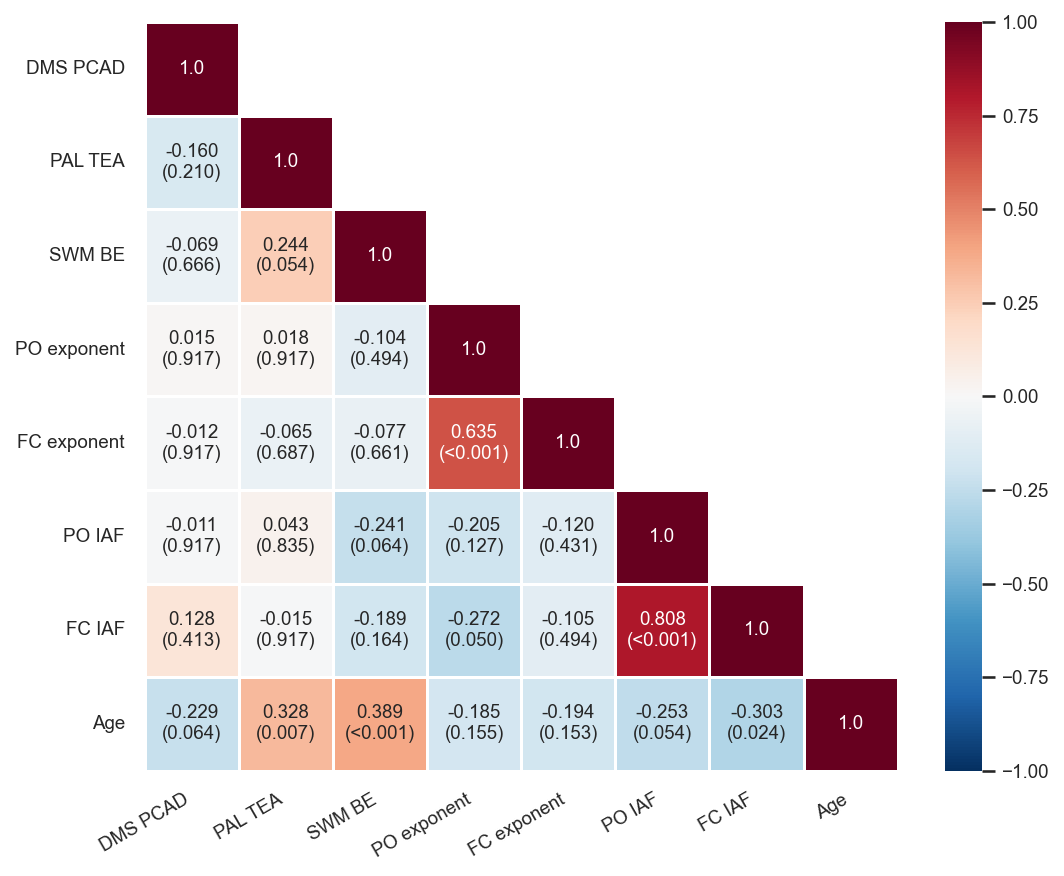

In [6]:
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests

correlation_list = ['DMSPCAD_z', 'PALTEA_z', 'SWMBE_OR_z', 'Exponent_po', 'Exponent_fc', 'IAF_po', 'IAF_fc', 'Age']

correlation_matrix = pd.DataFrame(index=correlation_list, columns=correlation_list)
p_value_matrix = pd.DataFrame(index=correlation_list, columns=correlation_list)

all_p_values = []
p_value_locs = []

# Compute pairwise Spearman correlation and p-values
for col1 in correlation_list:
    for col2 in correlation_list:
        if col1 == col2:
            correlation_matrix.loc[col1, col2] = 1.000  
            p_value_matrix.loc[col1, col2] = np.nan  
        else:
            valid_data = fullsample_df_CLEAN[[col1, col2]].dropna()
            
            if not valid_data.empty:
                corr, p_value = spearmanr(valid_data[col1], valid_data[col2])
                
                correlation_matrix.loc[col1, col2] = f"{corr:.3f}"
                p_value_matrix.loc[col1, col2] = p_value
                
                all_p_values.append(p_value)
                p_value_locs.append((col1, col2))
            else:
                correlation_matrix.loc[col1, col2] = np.nan
                p_value_matrix.loc[col1, col2] = np.nan

# Apply FDR correction to the list of p-values
rejected, pvals_corrected, _, _ = multipletests(all_p_values, alpha=0.05, method='fdr_bh')

# Replace the original p-values in the matrix with the FDR-corrected p-values
for idx, (col1, col2) in enumerate(p_value_locs):
    p_value_matrix.loc[col1, col2] = pvals_corrected[idx]

annot_matrix = correlation_matrix.copy()

# Iterate through the p_value_matrix and format the annotations
for col1 in correlation_list:
    for col2 in correlation_list:
        if pd.notna(p_value_matrix.loc[col1, col2]):
            if p_value_matrix.loc[col1, col2] < 0.001:
                annot_matrix.loc[col1, col2] = f"{correlation_matrix.loc[col1, col2]}\n(<0.001)"
            else:
                annot_matrix.loc[col1, col2] = f"{correlation_matrix.loc[col1, col2]}\n({p_value_matrix.loc[col1, col2]:.3f})"

renaming_dict = {
    'DMSPCAD_z': "DMS PCAD", 
    'PALTEA_z': "PAL TEA",
    'SWMBE_OR_z': "SWM BE",
    'Exponent_po': "PO exponent", 
    'Exponent_fc': "FC exponent", 
    'IAF_po': "PO IAF", 
    'IAF_fc': "FC IAF"
}

correlation_matrix.rename(columns=renaming_dict, index=renaming_dict, inplace=True)
annot_matrix.rename(columns=renaming_dict, index=renaming_dict, inplace=True)

sns.set_theme(style='white')

cmap = plt.get_cmap("RdBu_r")

plt.figure(figsize=(7.5, 6), dpi=150)
ax = sns.heatmap(
    correlation_matrix.astype(float), 
    cmap=cmap, # coolwarm
    fmt="", 
    cbar=True, 
    mask=np.triu(np.ones_like(correlation_matrix, dtype=bool), k=1),
    annot=annot_matrix,
    annot_kws={"size": 9},
    linewidths=.5,
    vmin=-1.0, 
    vmax=1.0 ,  
    center=0.0 
)

xticklabels = ax.get_xticklabels()
yticklabels = ax.get_yticklabels()

# xticklabels[-1] = ''
# yticklabels[0] = ''

ax.set_xticklabels(xticklabels, rotation=30, ha='right', fontsize=9)
ax.set_yticklabels(yticklabels, rotation=0, fontsize=9)

cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=9)

plt.tight_layout()

# Save the plot to file
# plt.savefig('results/plots/corrmatrix.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

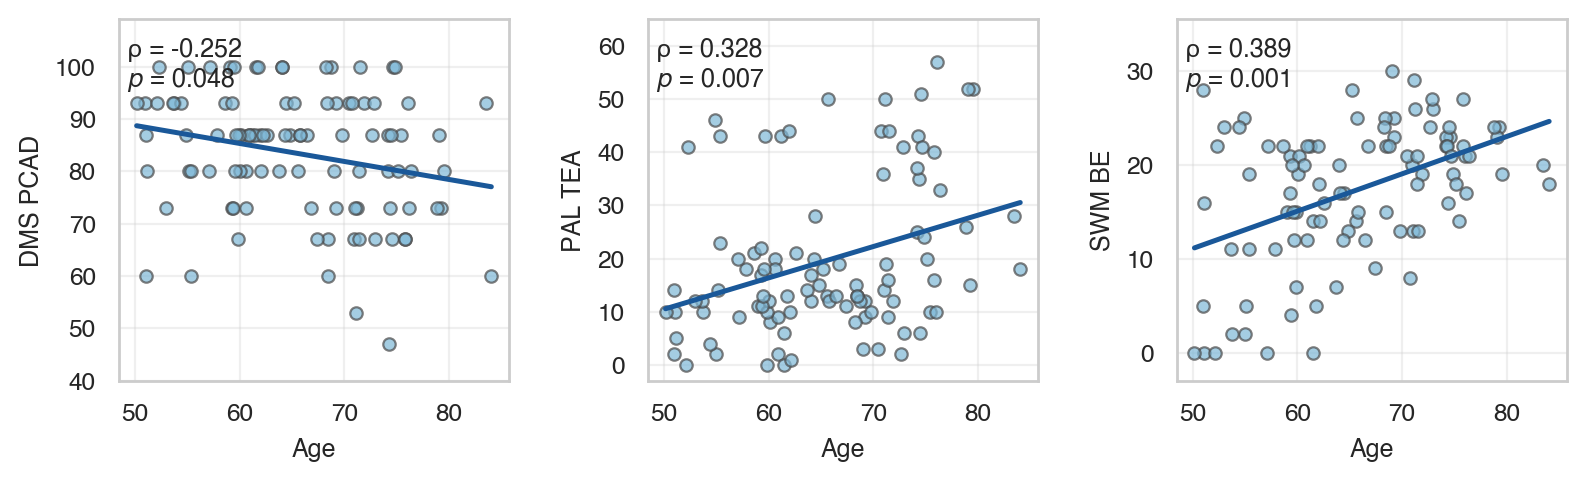

In [7]:
cog_y_labels = {
    'DMSPCAD': 'DMS PCAD',
    'PALTEA': 'PAL TEA',
    'SWMBE_OR': 'SWM BE'
}

cog_stats_dict = {
    ('Age', 'DMSPCAD'): {'r': -0.252, 'pval': 0.048},
    ('Age', 'PALTEA'): {'r': 0.328, 'pval': 0.007},
    ('Age', 'SWMBE_OR'): {'r': 0.389, 'pval': 0.001},
}

cog_y_limits = {
    'DMSPCAD': (40, 109),  
    'PALTEA': (-3, 65),  
    'SWMBE_OR': (-3, 35.5)
}

x = 'Age'
y_variables = ['DMSPCAD', 'PALTEA', 'SWMBE_OR']

sns.set_theme(style='whitegrid', font='Helvetica', context='paper')
plt.rc('grid', linestyle='-', alpha=0.3)

fig, axes = plt.subplots(1, len(y_variables), figsize=(210/25.4, 70/25.4), dpi=200)

for ax, y in zip(axes, y_variables):
    # Scatter plot
    sns.scatterplot(ax=ax, data=fullsample_df_CLEAN, x=x, y=y, 
                    color=cmap(0.275), edgecolor='#494949', s=20, lw=0.8, alpha=0.7)
    
    # Regression line
    sns.regplot(ax=ax, data=fullsample_df_CLEAN, x=x, y=y, 
                scatter=False, color=cmap(0.075), ci=False)
    
    ax.set_ylim(cog_y_limits[y])
    
    # Add stats text
    stat_text = cog_stats_dict[(x, y)]
    ax.text(0.02, 0.95, f"ρ = {stat_text['r']:.3f}\n$\\mathit{{p}}$ = {stat_text['pval']:.3f}",
            transform=ax.transAxes, va='top', fontsize=9)
    
    # Set labels and title
    ax.set_xlabel('Age', fontsize=9)
    ax.set_ylabel(cog_y_labels[y], fontsize=9)

# Adjust layout
plt.tight_layout(pad=2.0)
#plt.savefig('results/plots/cogscatters.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

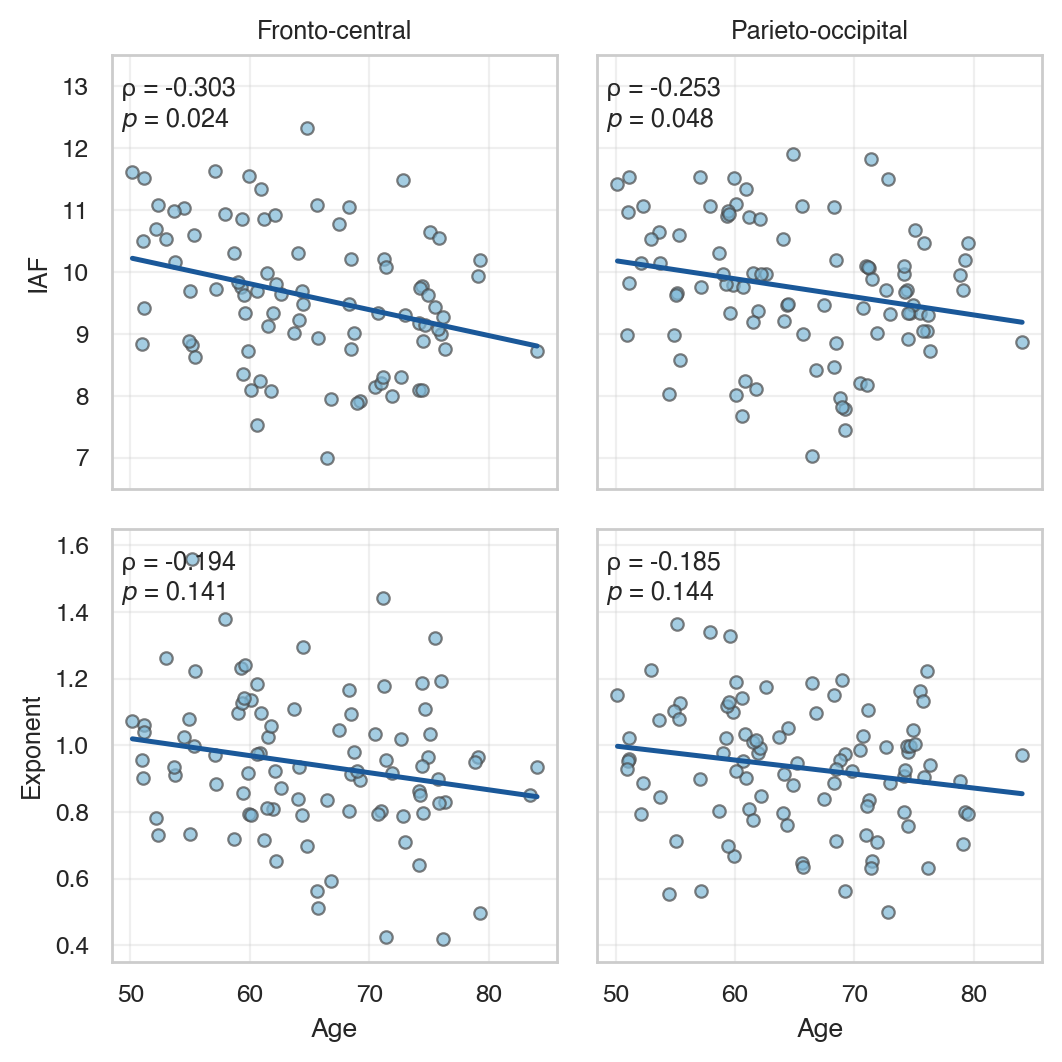

In [8]:
neuro_label_dict = {
    'fc': 'Fronto-central', 'po': 'Parieto-occipital', 'Exponent': 'Exponent', 'IAF': 'IAF' 
}
neuro_stats_dict = {
    ('Age', 'Exponent_fc'): {'r': -0.194, 'pval': 0.141}, 
    ('Age', 'Exponent_po'): {'r': -0.185, 'pval': 0.144}, 
    ('Age', 'IAF_fc'): {'r': -0.303, 'pval': 0.024}, 
    ('Age', 'IAF_po'): {'r': -0.253, 'pval': 0.048}, 
}

plt.rcParams.update({'font.size': 9})

sns.set_theme(style='whitegrid', font='Helvetica', context='paper')
plt.rc('grid', linestyle='-', alpha=0.3)

fig, axs = plt.subplots(2, 2, figsize=(140/25.4, 140/25.4), dpi=200) # 140/25.4, 140/25.4

x = 'Age'
neuro_limits = {'Exponent': [0.35, 1.65], 'IAF': [6.5, 13.5]}

for i, measure in enumerate(['IAF', 'Exponent']):
    for j, roi in enumerate(['fc', 'po']):
        y = f'{measure}_{roi}'
        ax = axs[i,j]

        plot_args = dict(ax=ax, data=fullsample_df_CLEAN, x=x, y=y)
        ax = sns.scatterplot(**plot_args, color=cmap(0.275), edgecolor='#494949', s=20, lw=0.8, alpha=0.7)
        ax = sns.regplot(**plot_args, scatter=False, color=cmap(0.075), ci=False)

        if j == 0:
            ax.set_ylabel(neuro_label_dict[measure], fontsize=9)
        else:
            ax.set_ylabel('')
            ax.set_yticklabels('')
        if i == 0:
            ax.set_title(neuro_label_dict[roi], fontsize=9)
            ax.set_xlabel('')
            ax.set_xticklabels('')
        
        ax.set_ylim(neuro_limits[measure])

        stat_text = neuro_stats_dict[(x, y)]
        ax.text(0.02, 0.95, f"ρ = {stat_text['r']:.3f}\n$\\mathit{{p}}$ = {stat_text['pval']:.3f}",
            transform=ax.transAxes, va='top', fontsize=9)

plt.tight_layout(pad=1.5)
# plt.savefig('results/plots/neuroscatter.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()

### *Heirachical linear regressions / Simple slopes analysis and plots*


---
iv=Exponent_fc, dv=DMSPCAD_z, step 3 model p-val = 0.034

sizes:
group
Mean           64
High (≥1SD)    14
Low (≤-1SD)    13
Name: count, dtype: int64

Simple Slope Analysis for Low (≤-1SD) Exponent_fc:
Slope: -0.493, SE: 0.159, t-value: -3.102, p-value: 0.003, 95% CI: [-0.809, -0.177]

Simple Slope Analysis for Mean Exponent_fc:
Slope: -0.258, SE: 0.107, t-value: -2.404, p-value: 0.018, 95% CI: [-0.471, -0.045]

Simple Slope Analysis for High (≥1SD) Exponent_fc:
Slope: -0.023, SE: 0.147, t-value: -0.155, p-value: 0.877, 95% CI: [-0.315, 0.270]

Simple Slope Analysis for Low (≤-1SD) Age:
Slope: -0.345, SE: 0.155, t-value: -2.228, p-value: 0.029, 95% CI: [-0.652, -0.037]

Simple Slope Analysis for Mean Age:
Slope: -0.110, SE: 0.105, t-value: -1.044, p-value: 0.299, 95% CI: [-0.318, 0.099]

Simple Slope Analysis for High (≥1SD) Age:
Slope: 0.125, SE: 0.148, t-value: 0.846, p-value: 0.400, 95% CI: [-0.169, 0.420]

---
iv=Exponent_po, dv=PALTEA_z, step 3 model p-val = 0.028

sizes:
gr

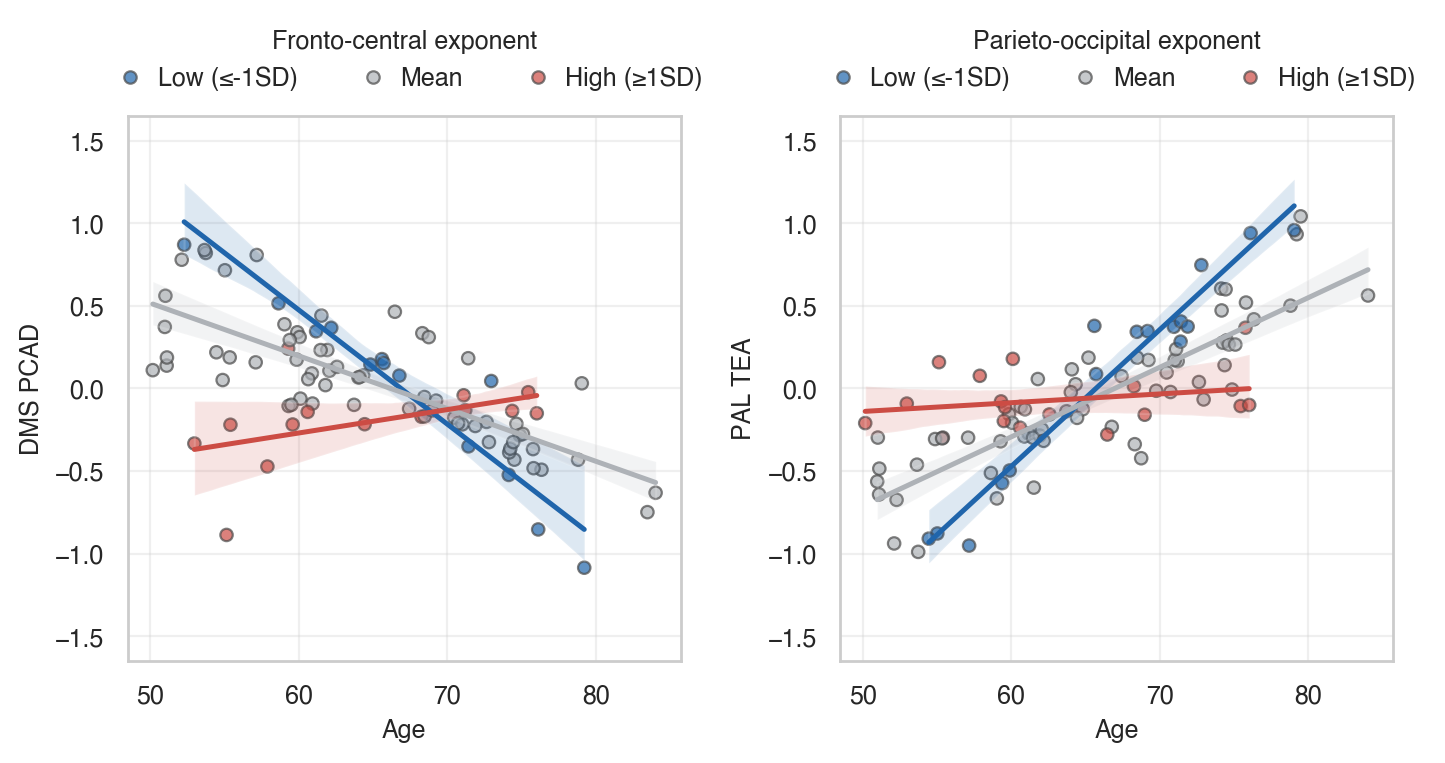

In [9]:
def simple_slope_analysis(model, level, var='Age_zscore', interaction='Age_Exponent_po'):
    
    # step3 model covariance matrix, coefficients, and DoF
    b_var, b_int = model.params[var], model.params[interaction]
    cov_matrix = model.cov_params()
    df = model.df_resid

    # calculate slope at the specified level of iv
    slope = b_var + b_int * level

    # variances and covariance from the covariance matrix
    var_var = cov_matrix.loc[var, var]
    var_int = cov_matrix.loc[interaction, interaction]
    cov_age_int = cov_matrix.loc[var, interaction]

    # slope SE, tval, pval, and CIs
    se = np.sqrt(var_var + level**2 * var_int + 2 * level * cov_age_int)
    tval = slope / se
    pval = 2 * (1 - stats.t.cdf(np.abs(tval), df))
    ci = [slope-stats.t.ppf(0.975, df)*se, slope+stats.t.ppf(0.975, df)*se]
    return slope, se, tval, pval, ci

dict_hlr = {}
df_ = fullsample_df_CLEAN.copy()

sns.set_theme(style='whitegrid', font='Helvetica', context='paper') 
plt.rc('grid', linestyle='-', alpha=0.3)
plt.rcParams.update({
    'font.size':9,
    'axes.labelsize':9,
    'axes.titlesize':9,
    'xtick.labelsize':9,
    'ytick.labelsize':9,
    'legend.fontsize':9,
    'legend.title_fontsize':9
})
(fig, axs), i = plt.subplots(1, 2, figsize=(180/25.4, 90/25.4), dpi=200), 0

dict_labels = {
    'Exponent_fc': 'Fronto-central exponent', 'Exponent_po': 'Parieto-occipital exponent',
    'DMSPCAD_z_pred': 'DMS PCAD', 'PALTEA_z_pred': 'PAL TEA',
}
# colors = ['#2E627AFF', '#AEB2B7FF', '#B53737FF']
colors = [cmap(0.1), '#AEB2B7FF', cmap(0.825)]
grp_conditions = {'Low (≤-1SD)':-1, 'Mean': 0, 'High (≥1SD)': 1}

import os
HLR_output_dir = 'results/hlr_summaries'
os.makedirs(HLR_output_dir, exist_ok=True)

# slope_output_dir = 'results/simple_slope_analyses'
# os.makedirs(slope_output_dir, exist_ok=True)

covars = ['Age_zscore', 'Gender_F', 'Education', 'Handedness_right']
for iv in ['Exponent_fc', 'Exponent_po', 'IAF_fc', 'IAF_po']:
    for dv in ['DMSPCAD_z' , 'PALTEA_z', 'SWMBE_OR_z']:
        X = {
            1: covars,
            2: covars + [f'{iv}_zscore'],
            3: covars + [f'{iv}_zscore'] + [f'Age_{iv}']
        }

        df_t = df_[['Subject', 'Age']+X[3]+[dv]].dropna()

        hlr_model = HierarchicalLinearRegression(df_t, X, dv)
        hlr_summary = hlr_model.summary()

        hlr_summary_csv_path = os.path.join(HLR_output_dir, f'hlr_summary_{iv}_{dv}.csv')
        # hlr_summary.to_csv(hlr_summary_csv_path, index=False)

        # predict dv values based on final model
        s3_model = hlr_model.fit_models()[3]
        df_t[f'{dv}_pred'] = s3_model.predict(sm.add_constant(df_t[X[3]]))

        # add HLR model and step3 LM results to dict
        dict_hlr[(iv, dv)] = {'hlr_model': hlr_model, 'hlr_summary': hlr_summary,
                              's3_model': s3_model, 's3_df': df_t}
        
        # check final model significance
        s3_pval = hlr_summary.iloc[2]['P-value (F-value change)']
        if s3_pval < 0.05:
            print(f'\n---\niv={iv}, dv={dv}, step 3 model p-val = {s3_pval:.3f}')

            df_t.loc[:, 'group'] = np.where(df_t[f'{iv}_zscore'] >= grp_conditions['High (≥1SD)'], 'High (≥1SD)',
                np.where(df_t[f'{iv}_zscore'] <= grp_conditions['Low (≤-1SD)'], 'Low (≤-1SD)', 'Mean'))

            print(f'\nsizes:\n{df_t['group'].value_counts()}')

            desired_order = ['Low (≤-1SD)', 'Mean', 'High (≥1SD)']
            ax = axs[i]
            sns.scatterplot(ax=ax,x='Age', y=f'{dv}_pred', data=df_t, hue='group', hue_order=desired_order, 
                            palette=colors, edgecolor='#494949', lw=0.8, s=20, alpha=0.7)
            for c, g_lab in enumerate(grp_conditions.keys()):
                sns.regplot(ax=ax, x='Age', y=f'{dv}_pred', data=df_t[df_t['group']==g_lab], color=colors[c], scatter=False)
            ax.legend(title=dict_labels[iv], ncols=3, loc='upper center', frameon=False, bbox_to_anchor=(0.5, 1.2), 
                      handletextpad=0.1, columnspacing=2)
            ax.set_ylabel(dict_labels[f'{dv}_pred'])
            ax.set_ylim([-1.65, 1.65])

            # slope analysis
            simple_slope_results = {}
            for iv_group, iv_level in grp_conditions.items():
                slope, se, tval, pval, ci = simple_slope_analysis(model=s3_model, level=iv_level, var=f'Age_zscore', interaction=f'Age_{iv}')
                print(f"\nSimple Slope Analysis for {iv_group} {iv}:")
                print(f"Slope: {slope:.3f}, SE: {se:.3f}, t-value: {tval:.3f}, p-value: {pval:.3f}, 95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")
            for iv_group, iv_level in grp_conditions.items():
                slope, se, tval, pval, ci = simple_slope_analysis(model=s3_model, level=iv_level, var=f'{iv}_zscore', interaction=f'Age_{iv}')
                print(f"\nSimple Slope Analysis for {iv_group} Age:")
                print(f"Slope: {slope:.3f}, SE: {se:.3f}, t-value: {tval:.3f}, p-value: {pval:.3f}, 95% CI: [{ci[0]:.3f}, {ci[1]:.3f}]")

            i += 1

plt.tight_layout(pad=-0.3)
# plt.savefig('results/plots/simpleslopesplot.pdf', format='pdf', bbox_inches='tight', dpi=300)
plt.show()